In [23]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score
import seaborn as sns
from tqdm import tqdm
import shutil
import time

In [24]:
# --- CONFIGURATION ---
DATA_ROOT = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2"  # Your root folder
NORMAL_CLASS_NAME = "NormalVideos" # Change this if your folder is named 'Normal_Videos_event'
STAGE_2_DATA_ROOT = "stage2_extracted_frames" # Where we will save frames for Stage 2

# Hyperparameters
BATCH_SIZE = 8
NUM_SEGMENTS = 16  # How many clips/frames to sample per video in Stage 1
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_N_FRAMES = 15   # How many "evidence" frames to extract per video for Stage 2

print(f"Running on device: {DEVICE}")

Running on device: cuda


### Data Exploration

In [25]:
def count_videos(root_dir):
    total = 0
    total_anoms = 0
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        # Count subdirectories (each subdirectory is a video folder)
        num_videos = sum(
            1 for file in os.listdir(cls_path)
            if file.lower().endswith('.mp4')
        )
        num_anoms = sum(
            1 for file in os.listdir(cls_path)
            if cls != NORMAL_CLASS_NAME and file.lower().endswith('.mp4')
            
        )

        print(f"{cls}: {num_videos} videos")
        
        total += num_videos
        total_anoms += num_anoms
    print(f"Anomolous: {total_anoms} videos")
    return total

train_count = count_videos(DATA_ROOT + "/Train")
test_count = count_videos(DATA_ROOT + "/Test")
val_count = count_videos(DATA_ROOT + "/Validation")

print(f"\nTotal Train videos: {train_count}")
print(f"Total Test videos: {test_count}")
print(f"Total Validation videos: {val_count}")

Abuse: 40 videos
Arrest: 40 videos
Arson: 40 videos
Assault: 40 videos
Burglary: 80 videos
Explosion: 40 videos
Fighting: 40 videos
NormalVideos: 170 videos
RoadAccidents: 120 videos
Robbery: 120 videos
Shooting: 40 videos
Shoplifting: 40 videos
Stealing: 80 videos
Vandalism: 40 videos
Anomolous: 760 videos
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 150 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos
Anomolous: 95 videos
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 19 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos
Anomolous: 95 videos

Total Train videos: 930
Total Test videos: 245
Total Validation videos: 114


In [26]:
class UCFCrimeBinaryDataset(Dataset):
    def __init__(self, root_dir, split="Train", num_segments=16, transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.num_segments = num_segments
        self.samples = [] 
        
        # Walk through directories
        for class_name in os.listdir(self.root_dir):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path): continue
            
            # Binary Label: 0 if Normal, 1 if Crime
            label = 0 if class_name == NORMAL_CLASS_NAME else 1
            
            for vid_file in os.listdir(class_path):
                self.samples.append((os.path.join(class_path, vid_file), label, class_name))

    def __len__(self):
        return len(self.samples)

    def load_video_segments(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames < 1: return torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

        # Uniform sampling
        indices = np.linspace(0, total_frames-1, self.num_segments).astype(int)
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            else:
                # Padding if read fails
                frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
        cap.release()
        
        # Stack to shape (Segments, C, H, W)
        return torch.stack(frames) if frames else torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        path, label, original_class = self.samples[idx]
        video_tensor = self.load_video_segments(path) # Shape: (T, C, H, W)
        return video_tensor, torch.tensor(label, dtype=torch.float32), path, original_class

# --- STAGE 1 MODEL: MIL ResNet ---
class Stage1MILModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature Extractor (ResNet18)
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove fc
        
        # Classifier Head (Instance Level)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (Batch, Segments, C, H, W)
        b, t, c, h, w = x.size()
        
        # Merge Batch and Time for CNN processing
        x = x.view(b * t, c, h, w) 
        
        features = self.feature_extractor(x) # (B*T, 512, 1, 1)
        features = features.view(features.size(0), -1) # (B*T, 512)
        
        # Get instance (segment) scores
        segment_scores = self.classifier(features) # (B*T, 1)
        
        # Reshape back to (Batch, Segments)
        segment_scores = segment_scores.view(b, t)
        
        # MIL Aggregation: Max Pooling (The video score is the max segment score)
        # We return both the video score AND the segment scores (for frame extraction)
        video_score, _ = torch.max(segment_scores, dim=1)
        
        return video_score, segment_scores

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=1.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        # inputs: model predictions (after sigmoid)
        # targets: ground truth labels
        bce_loss = -targets * torch.log(inputs + 1e-8) - (1 - targets) * torch.log(1 - inputs + 1e-8)
        pt = torch.where(targets == 1, inputs, 1 - inputs)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [28]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loaders
train_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Train", transform=train_transform)
test_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Test", transform=test_transform)
val_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Validation", transform=test_transform)

train_loader_s1 = DataLoader(train_ds_s1, batch_size=BATCH_SIZE, shuffle=True)
test_loader_s1 = DataLoader(test_ds_s1, batch_size=1, shuffle=False) # Batch 1 for easier extraction

# Init Model
model_s1 = Stage1MILModel().to(DEVICE)
optimizer_s1 = optim.AdamW(model_s1.parameters(), lr=1e-4, weight_decay=1e-4)
criterion_s1 = FocalLoss(alpha=0.5, gamma=2.0)
#criterion_s1 = nn.BCELoss()

# --- TRAINING LOOP STAGE 1 ---
def train_stage1(epochs=1):
    model_s1.train()
    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        loop = tqdm(train_loader_s1, desc=f"Stage 1 Epoch {epoch+1}")
        for videos, labels, _, _ in loop:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            
            optimizer_s1.zero_grad()
            video_preds, _ = model_s1(videos)
            
            loss = criterion_s1(video_preds, labels)
            loss.backward()
            optimizer_s1.step()
            
            epoch_loss += loss.item()
            
            # Track predictions for metrics
            preds_binary = (video_preds > 0.5).float()
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader_s1)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='binary')
        
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")
    
    elapsed_time = time.time() - start_time
    print(f"\nStage 1 Training completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
    return history

# Run Training
print("Starting Stage 1 Training...")
stage1_history = train_stage1(epochs=6) # Increase epochs for real results

# --- THE PIPE: EXTRACTION ---
# We will iterate through the dataset. If the model says "Crime" (or if it IS a crime in training),
# we extract top N frames and save them for Stage 2.

def extract_frames_for_stage2(dataset, split_name):
    print(f"Extracting frames for {split_name}...")
    model_s1.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    start_time = time.time()
    
    import glob

    with torch.no_grad():
        for videos, labels, paths, original_classes in tqdm(loader):
            videos = videos.to(DEVICE)
            path = paths[0]
            orig_class = original_classes[0]
            
            # Skip Normal videos for Stage 2
            if orig_class == NORMAL_CLASS_NAME:
                continue

            # Get scores
            video_score, segment_scores = model_s1(videos)
            
            # Identify Top N indices
            scores = segment_scores[0].cpu().numpy()
            top_indices = scores.argsort()[-TOP_N_FRAMES:][::-1]
            
            # Sort indices to maintain temporal order
            top_indices = np.sort(top_indices)
            
            # Prepare save directory
            save_dir = os.path.join(STAGE_2_DATA_ROOT, split_name, orig_class)
            os.makedirs(save_dir, exist_ok=True)

            # Remove existing frames for this video: delete any file that contains the video name
            vid_name = os.path.basename(path).split('.')[0]
            for f in glob.glob(os.path.join(save_dir, f"*{vid_name}*")):
                try:
                    os.remove(f)
                except Exception:
                    pass

            # Extract frames in temporal order
            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_indices_to_grab = np.linspace(0, total_frames-1, NUM_SEGMENTS).astype(int)[top_indices]

            for idx, frame_idx in enumerate(frame_indices_to_grab):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    # Save with sequential index to maintain order
                    save_path = os.path.join(save_dir, f"{vid_name}_frame{idx:02d}.jpg")
                    cv2.imwrite(save_path, frame)
            cap.release()
    
    elapsed_time = time.time() - start_time
    elapsed_time = elapsed_time - 600
    print(f"Frame extraction for {split_name} completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Run Extraction
extract_frames_for_stage2(train_ds_s1, "Train")
extract_frames_for_stage2(test_ds_s1, "Test")
extract_frames_for_stage2(val_ds_s1, "Validation")

Starting Stage 1 Training...


Stage 1 Epoch 1: 100%|██████████| 117/117 [04:06<00:00,  2.10s/it, loss=0.0146]


Epoch 1/6 - Loss: 0.0467, Acc: 0.8387, F1: 0.9062


Stage 1 Epoch 2: 100%|██████████| 117/117 [04:08<00:00,  2.12s/it, loss=0.0198]


Epoch 2/6 - Loss: 0.0413, Acc: 0.8763, F1: 0.9254


Stage 1 Epoch 3: 100%|██████████| 117/117 [04:24<00:00,  2.26s/it, loss=0.0159]


Epoch 3/6 - Loss: 0.0350, Acc: 0.8989, F1: 0.9397


Stage 1 Epoch 4: 100%|██████████| 117/117 [04:08<00:00,  2.12s/it, loss=0.0107]


Epoch 4/6 - Loss: 0.0315, Acc: 0.9118, F1: 0.9467


Stage 1 Epoch 5: 100%|██████████| 117/117 [04:06<00:00,  2.11s/it, loss=0.00427]


Epoch 5/6 - Loss: 0.0329, Acc: 0.9151, F1: 0.9485


Stage 1 Epoch 6: 100%|██████████| 117/117 [04:06<00:00,  2.11s/it, loss=0.0074]


Epoch 6/6 - Loss: 0.0276, Acc: 0.9290, F1: 0.9572

Stage 1 Training completed in 1499.49 seconds (24.99 minutes)
Extracting frames for Train...


100%|██████████| 930/930 [06:26<00:00,  2.40it/s]


Frame extraction for Train completed in -213.21 seconds (-3.55 minutes)
Extracting frames for Test...


100%|██████████| 245/245 [01:17<00:00,  3.18it/s]


Frame extraction for Test completed in -522.91 seconds (-8.72 minutes)
Extracting frames for Validation...


100%|██████████| 114/114 [00:45<00:00,  2.50it/s]

Frame extraction for Validation completed in -554.41 seconds (-9.24 minutes)


In [29]:
# --- QUICK STRATIFIED SUBSET TRAINING (No frame extraction) ---
# Purpose: fast hyperparameter testing for Stage 1 (focal loss alpha/gamma)
# - Uses a stratified subset of the training samples (preserves class distribution)
# - Returns synthetic video tensors (no cv2 / disk frame reads)
# - Lightweight copy of the Stage1 model trained for a small number of epochs

import random
from torch.utils.data import Dataset, DataLoader


class QuickSubsetDataset(Dataset):
    """Lightweight dataset that returns synthetic video tensors for fast tests.

    Each item preserves the original label and path but returns a random
    tensor shaped (num_segments, 3, IMG_SIZE, IMG_SIZE). This avoids
    expensive video/frame IO while keeping the same class balance.
    """
    def __init__(self, original_dataset, indices, num_segments=NUM_SEGMENTS, img_size=IMG_SIZE, seed=0):
        self.samples = [original_dataset.samples[i] for i in indices]
        self.num_segments = num_segments
        self.img_size = img_size
        self.rng = np.random.RandomState(seed)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, orig_class = self.samples[idx]

        # Synthetic video tensor: (T, C, H, W)
        arr = self.rng.randn(self.num_segments, 3, self.img_size, self.img_size).astype(np.float32)
        video_tensor = torch.from_numpy(arr)

        return video_tensor, torch.tensor(label, dtype=torch.float32), path, orig_class


def stratified_indices_from_samples(samples, fraction=0.1, min_per_class=1, seed=0):
    """Return a list of indices sampled per-class to preserve distribution.

    samples: list of tuples (path, label, class_name)
    fraction: fraction of each class to keep (e.g., 0.05 = 5%)
    min_per_class: minimum samples per class to include
    """
    label_to_indices = {}
    for i, (_, label, _) in enumerate(samples):
        lab = int(label)
        label_to_indices.setdefault(lab, []).append(i)

    rng = random.Random(seed)
    selected = []
    for label, idxs in label_to_indices.items():
        k = max(min_per_class, int(len(idxs) * fraction))
        k = min(k, len(idxs))
        # If k equals available count just take all
        if k == len(idxs):
            selected.extend(idxs)
        else:
            selected.extend(rng.sample(idxs, k))

    return selected


def quick_train_stage1_subset(fraction=0.05, epochs=2, alpha=0.5, gamma=2.0, seed=12, lr=1e-4):
    """Quick training run on a stratified subset. Returns (model, history, indices).

    - fraction: fraction of each class to keep (keeps class ratios)
    - epochs: small number for quick tests
    - alpha/gamma: focal loss hyperparameters to test
    - NOTE: This does NOT perform any frame extraction and uses synthetic tensors.
    """
    indices = stratified_indices_from_samples(train_ds_s1.samples, fraction=fraction, min_per_class=1, seed=seed)
    print(f"Selected {len(indices)} samples ({len(indices)/len(train_ds_s1):.2%} of original) stratified by class")

    quick_ds = QuickSubsetDataset(train_ds_s1, indices, num_segments=NUM_SEGMENTS, img_size=IMG_SIZE, seed=seed)
    quick_loader = DataLoader(quick_ds, batch_size=BATCH_SIZE, shuffle=True)

    # Fresh model copy so main model weights are untouched
    quick_model = Stage1MILModel().to(DEVICE)
    optimizer = optim.AdamW(quick_model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}

    quick_model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []

        loop = tqdm(quick_loader, desc=f"Quick Stage1 Epoch {epoch+1}/{epochs}")
        for videos, labels, _, _ in loop:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            video_preds, _ = quick_model(videos)

            loss = criterion(video_preds, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            preds_binary = (video_preds > 0.5).float()
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / max(1, len(quick_loader))
        accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0
        f1 = f1_score(all_labels, all_preds, average='binary') if len(set(all_labels)) > 1 else 0

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)

        print(f"Quick Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")

    return quick_model, history, indices



In [30]:
quick_model, quick_history, quick_indices = quick_train_stage1_subset(fraction=0.05, epochs=2, alpha=0.6, gamma=1.0)

c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Selected 46 samples (4.95% of original) stratified by class


Quick Stage1 Epoch 1/2: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=0.0777]


Quick Epoch 1/2 - Loss: 0.1435, Acc: 0.8261, F1: 0.9048


Quick Stage1 Epoch 2/2: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=0.0615]

Quick Epoch 2/2 - Loss: 0.1455, Acc: 0.8261, F1: 0.9048


Evaluating Stage 1: 100%|██████████| 245/245 [00:56<00:00,  4.35it/s]



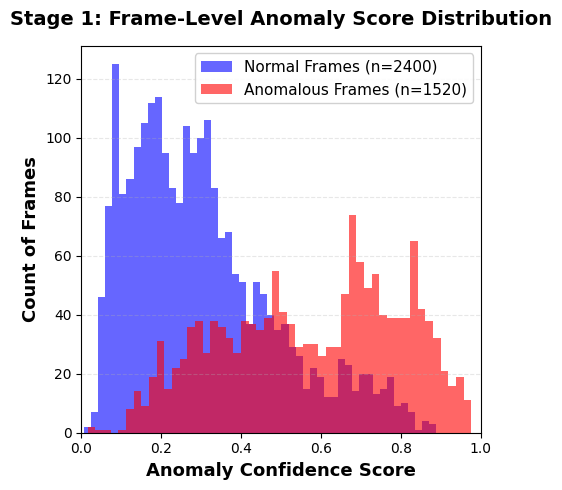

Stage 1 evaluation completed in 56.33 seconds (0.94 minutes)
Stage 1 Test Accuracy: 75.92%
Stage 1 Test F1 Score: 0.7230


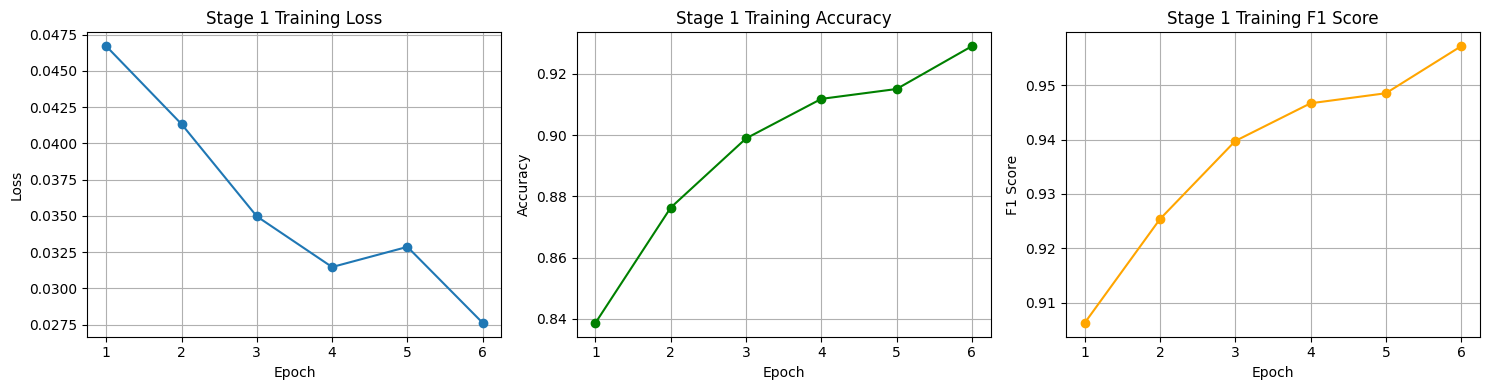

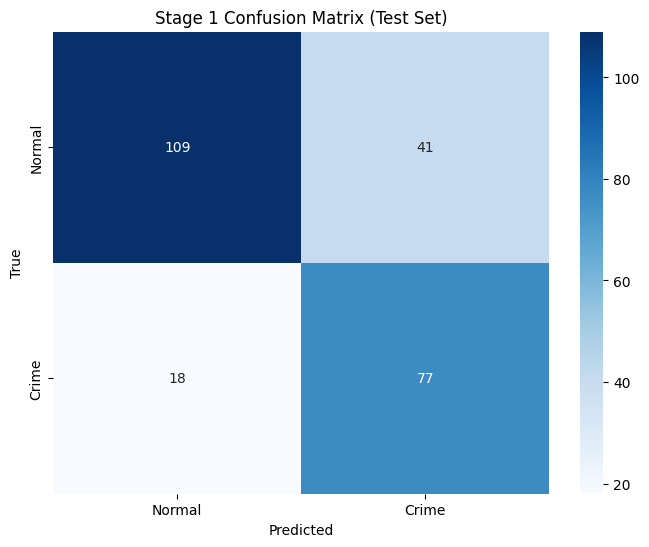

In [31]:
# --- STAGE 1 EVALUATION AND VISUALIZATION ---

def evaluate_stage1(loader, model, num_segments=16, plot_distribution=True, bins=50):
    """
    Evaluate Stage 1 model and optionally plot frame-level anomaly score distribution.
    
    Args:
        loader: DataLoader for evaluation
        model: Trained Stage 1 model
        num_segments: Number of segments per video
        plot_distribution: Whether to plot the frame-level score distribution
        bins: Number of bins for histogram
    
    Returns:
        acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores
    """
    model.eval()
    all_preds = []
    all_labels = []
    normal_frame_scores = []
    anomaly_frame_scores = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for videos, labels, _, _ in tqdm(loader, desc="Evaluating Stage 1"):
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            video_preds, segment_scores = model(videos)
            preds_binary = (video_preds > 0.5).float()
            
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect frame-level scores for distribution
            for i in range(len(labels)):
                scores = segment_scores[i].cpu().numpy()
                
                if labels[i].item() == 0:  # Normal
                    normal_frame_scores.extend(scores)
                else:  # Anomaly
                    anomaly_frame_scores.extend(scores)
    
    elapsed_time = time.time() - start_time
    
    # Convert to numpy arrays
    normal_frame_scores = np.array(normal_frame_scores)
    anomaly_frame_scores = np.array(anomaly_frame_scores)
    
    # Calculate video-level metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot frame-level anomaly score distribution
    if plot_distribution:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Create histograms
        ax.hist(normal_frame_scores, bins=bins, alpha=0.6, color='blue', 
                label=f'Normal Frames (n={len(normal_frame_scores)})', linewidth=0.5)
        ax.hist(anomaly_frame_scores, bins=bins, alpha=0.6, color='red', 
                label=f'Anomalous Frames (n={len(anomaly_frame_scores)})', linewidth=0.5)
        
        # Labels and title
        ax.set_xlabel('Anomaly Confidence Score', fontsize=13, fontweight='bold')
        ax.set_ylabel('Count of Frames', fontsize=13, fontweight='bold')
        ax.set_title('Stage 1: Frame-Level Anomaly Score Distribution', 
                     fontsize=14, fontweight='bold', pad=15)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        
        # Set x-axis limits
        ax.set_xlim(0, 1)
        
        
        plt.tight_layout()
        plt.show()
    
    print(f"Stage 1 evaluation completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
    return acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores


# Evaluate on test set (now includes frame-level distribution)
test_acc, test_f1, test_cm, test_preds, test_labels, normal_scores, anomaly_scores = evaluate_stage1(
    test_loader_s1, model_s1, num_segments=NUM_SEGMENTS, plot_distribution=True, bins=50
)

print(f"Stage 1 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 1 Test F1 Score: {test_f1:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(range(1, len(stage1_history['train_loss'])+1), stage1_history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 1 Training Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(stage1_history['train_acc'])+1), stage1_history['train_acc'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 1 Training Accuracy')
axes[1].grid(True)

# F1 Score plot
axes[2].plot(range(1, len(stage1_history['train_f1'])+1), stage1_history['train_f1'], marker='o', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Stage 1 Training F1 Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=['Normal', 'Crime'], yticklabels=['Normal', 'Crime'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 1 Confusion Matrix (Test Set)')
plt.show()


In [32]:
# --- STAGE 1: VIDEO CONFIDENCE OVER TIME VISUALIZATION ---

def get_video_confidence_timeline(model, video_path, num_segments=16, top_n=5):
    """
    Extract frame-by-frame confidence scores for a video.
    Returns frame indices, confidence scores, and top N frame indices.
    """
    model.eval()
    
    # Load video and get all sampled frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < 1:
        cap.release()
        return None, None, None
    
    # Get the frame indices that were sampled
    frame_indices = np.linspace(0, total_frames-1, num_segments).astype(int)
    
    # Load and process each frame
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frame = test_transform(frame)
            frames.append(frame)
        else:
            frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
    
    cap.release()
    
    # Stack frames and get predictions
    video_tensor = torch.stack(frames).unsqueeze(0).to(DEVICE)  # Shape: (1, T, C, H, W)
    
    with torch.no_grad():
        video_score, segment_scores = model(video_tensor)
    
    # Get segment scores (confidence of being anomalous/crime)
    segment_scores = segment_scores[0].cpu().numpy()  # Shape: (num_segments,)
    
    # Get top N frame indices
    top_indices = segment_scores.argsort()[-top_n:][::-1]
    top_frame_numbers = frame_indices[top_indices]
    
    return frame_indices, segment_scores, top_frame_numbers, video_score.item()


In [33]:
def plot_video_confidence_timeline(video_name, model, test_dataset, save_path=None):
    """
    Plot the confidence timeline for a specific video by name.
    
    Args:
        video_name: Name of the video file (e.g., "Abuse001_x264.mp4")
        model: Trained Stage 1 model
        test_dataset: The test dataset object
        save_path: Optional path to save the figure
    """
    # Find the video in the dataset
    video_path = None
    video_label = None
    video_class = None
    
    for path, label, orig_class in test_dataset.samples:
        if video_name in path:
            video_path = path
            video_label = label
            video_class = orig_class
            break
    
    if video_path is None:
        print(f"Video '{video_name}' not found in test dataset!")
        return
    
    # Get confidence timeline
    frame_indices, confidences, top_frames, overall_score = get_video_confidence_timeline(
        model, video_path, num_segments=NUM_SEGMENTS, top_n=TOP_N_FRAMES
    )
    
    if frame_indices is None:
        print(f"Failed to process video: {video_name}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot confidence scores (no markers on the line itself)
    ax.plot(frame_indices, confidences, linewidth=2, color='#2E86AB', label='Anomaly Confidence')
    
    # Add markers only on the top N frames
    top_frame_confidences = confidences[np.isin(frame_indices, top_frames)]
    #ax.plot(top_frames, top_frame_confidences, '|', markersize=8, color='#2E86AB', markeredgecolor='#2E86AB', markeredgewidth=1.5, label='Top Evidence Frames', zorder=5)
    
    # Add horizontal line at 0.5 threshold
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (0.5)')
    
    # Group sequential top frames and highlight them
    # Sort top frames to check for sequential frames
    sorted_top_frames = np.sort(top_frames)
    
    # Find groups of sequential frames
    groups = []
    current_group = [sorted_top_frames[0]]
    
    for i in range(1, len(sorted_top_frames)):
        # Check if frames are adjacent in the original frame_indices
        current_idx = np.where(frame_indices == sorted_top_frames[i])[0][0]
        prev_idx = np.where(frame_indices == sorted_top_frames[i-1])[0][0]
        
        if current_idx - prev_idx == 1:  # Sequential frames
            current_group.append(sorted_top_frames[i])
        else:
            groups.append(current_group)
            current_group = [sorted_top_frames[i]]
    
    groups.append(current_group)  # Add the last group
    
    # Highlight each group with merged bars
    y_min, y_max = ax.get_ylim()
    for i, group in enumerate(groups):
        # For each group, create one wide bar that spans all frames
        start_frame = group[0] - 10
        end_frame = group[-1] + 10
        ax.axvspan(start_frame, end_frame, alpha=0.15, color="#FF0000", 
                   label='Top Evidence Region' if i == 0 else '')
    
    # Labels and title
    ax.set_xlabel('Frame Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Anomaly Confidence Score', fontsize=12, fontweight='bold')
    
    true_label = "Normal" if video_label == 0 else "Anomalous"
    pred_label = "Anomalous" if overall_score > 0.5 else "Normal"
    
    title = f'Video Anomaly Confidence Timeline\n'
    title += f'Video: {video_name} | True Label: {true_label} ({video_class}) | '
    title += f'Predicted: {pred_label} (Score: {overall_score:.3f})'
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    # Add grid and legend
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.8, color='gray')
    ax.legend(loc='upper left', fontsize=10)
    
    # Set axis limits to match the data range
    ax.set_xlim(frame_indices[0], frame_indices[-1])
    ax.set_ylim(-0.05, 1.05)
    
    # Add axis spines (borders) for x and y axes
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['top'].set_color('black')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Video: {video_name}")
    print(f"True Label: {true_label} ({video_class})")
    print(f"Overall Anomaly Score: {overall_score:.4f}")
    print(f"Prediction: {pred_label}")
    print(f"\nTop {TOP_N_FRAMES} Evidence Frames:")
    for i, (frame_num, score) in enumerate(zip(top_frames, confidences[np.isin(frame_indices, top_frames)])):
        print(f"  #{i+1}: Frame {frame_num} (Confidence: {score:.4f})")
    print(f"{'='*60}\n")

In [34]:
def list_test_videos(test_dataset, class_filter=None, limit=10):
    """
    List available videos in the test dataset.
    
    Args:
        test_dataset: The test dataset object
        class_filter: Optional class name to filter by (e.g., "Abuse", "NormalVideos")
        limit: Maximum number of videos to display
    """
    print(f"Available test videos (showing up to {limit}):\n")
    print(f"{'Video Name':<40} {'Class':<20} {'Label'}")
    print("-" * 70)
    
    count = 0
    for path, label, orig_class in test_dataset.samples:
        if class_filter and orig_class != class_filter:
            continue
        
        video_name = os.path.basename(path)
        label_str = "Normal" if label == 0 else "Anomalous"
        print(f"{video_name:<40} {orig_class:<20} {label_str}")
        
        count += 1
        if count >= limit:
            break
    
    print(f"\nTotal videos in test set: {len(test_dataset.samples)}")
    if class_filter:
        filtered_count = sum(1 for _, _, c in test_dataset.samples if c == class_filter)
        print(f"Videos in '{class_filter}': {filtered_count}")

# Example: List all test videos
# list_test_videos(test_ds_s1, limit=20)

# Example: List only crime videos
# list_test_videos(test_ds_s1, class_filter="Abuse", limit=10)

In [35]:
list_test_videos(test_ds_s1, limit=20)

Available test videos (showing up to 20):

Video Name                               Class                Label
----------------------------------------------------------------------
Abuse003_x264.mp4                        Abuse                Anomalous
Abuse011_x264.mp4                        Abuse                Anomalous
Abuse013_x264.mp4                        Abuse                Anomalous
Abuse039_x264.mp4                        Abuse                Anomalous
Abuse047_x264.mp4                        Abuse                Anomalous
Arrest013_x264.mp4                       Arrest               Anomalous
Arrest015_x264.mp4                       Arrest               Anomalous
Arrest023_x264.mp4                       Arrest               Anomalous
Arrest024_x264.mp4                       Arrest               Anomalous
Arrest046_x264.mp4                       Arrest               Anomalous
Arson012_x264.mp4                        Arson                Anomalous
Arson021_x264.mp4         

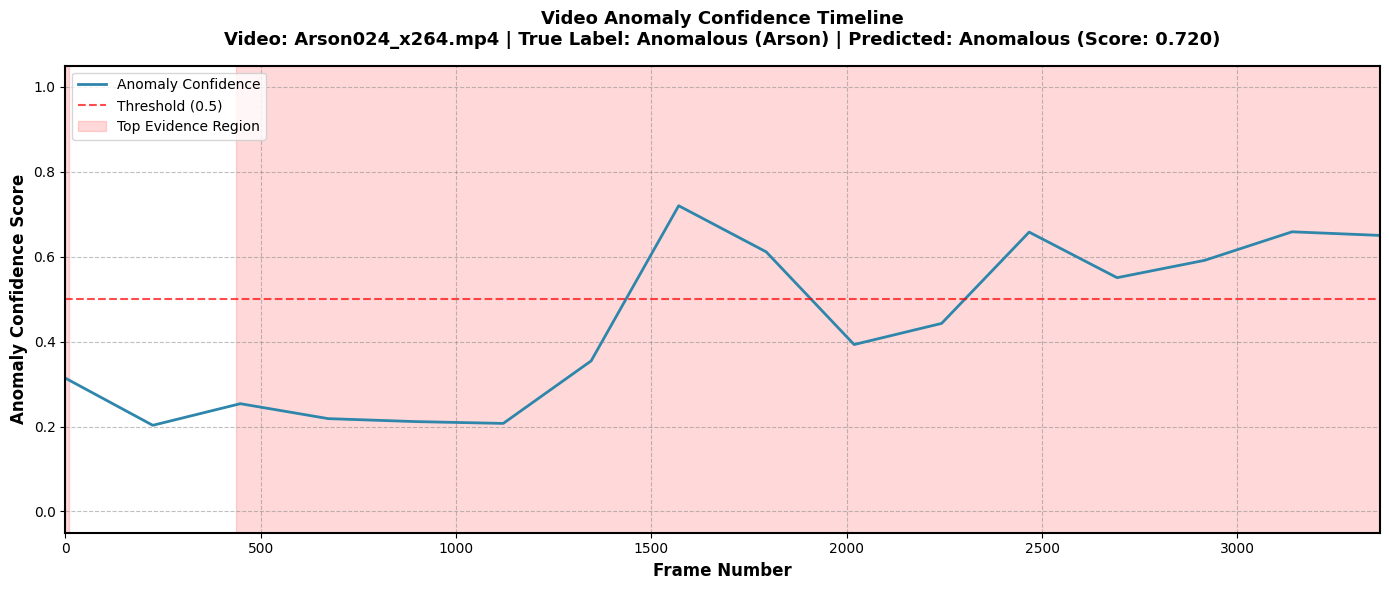


Video: Arson024_x264.mp4
True Label: Anomalous (Arson)
Overall Anomaly Score: 0.7201
Prediction: Anomalous

Top 15 Evidence Frames:
  #1: Frame 1570 (Confidence: 0.3141)
  #2: Frame 3140 (Confidence: 0.2539)
  #3: Frame 2467 (Confidence: 0.2187)
  #4: Frame 3365 (Confidence: 0.2117)
  #5: Frame 1794 (Confidence: 0.2074)
  #6: Frame 2916 (Confidence: 0.3547)
  #7: Frame 2692 (Confidence: 0.7201)
  #8: Frame 2243 (Confidence: 0.6114)
  #9: Frame 2019 (Confidence: 0.3931)
  #10: Frame 1346 (Confidence: 0.4430)
  #11: Frame 0 (Confidence: 0.6579)
  #12: Frame 448 (Confidence: 0.5506)
  #13: Frame 673 (Confidence: 0.5914)
  #14: Frame 897 (Confidence: 0.6587)
  #15: Frame 1121 (Confidence: 0.6502)



In [36]:
plot_video_confidence_timeline("Arson024_x264.mp4", model_s1, test_ds_s1)

In [37]:
class UCFCrime3DDataset(Dataset):
    def __init__(self, root_dir, num_frames=TOP_N_FRAMES, transform=None):
        """
        Dataset for loading sequences of frames for 3D CNN.
        
        Args:
            root_dir: Path to directory containing class folders
            num_frames: Number of frames per video sequence
            transform: Torchvision transforms for spatial augmentation
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        self.classes = []
        
        # Collect all video samples
        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            if class_name not in self.classes:
                self.classes.append(class_name)
            
            class_idx = self.classes.index(class_name)
            
            # Group frames by video name
            video_frames = {}
            for frame_file in os.listdir(class_path):
                if not frame_file.endswith('.jpg'):
                    continue
                
                # Extract video name - handle both _rank and _frame patterns
                if '_frame' in frame_file:
                    video_name = frame_file.rsplit('_frame', 1)[0]
                
                if video_name not in video_frames:
                    video_frames[video_name] = []
                
                video_frames[video_name].append(os.path.join(class_path, frame_file))
            
            # Add each video as a sample (only if it has correct number of frames)
            for video_name, frame_paths in video_frames.items():
                # Sort frames to maintain temporal order
                frame_paths = sorted(frame_paths)
                
                # Only include videos with correct number of frames
                if len(frame_paths) == self.num_frames:
                    self.samples.append((frame_paths, class_idx))
                else:
                    print(f"⚠️ Skipping {video_name}: has {len(frame_paths)} frames, expected {self.num_frames}")
        
        print(f"Loaded {len(self.samples)} video sequences across {len(self.classes)} classes")
        if len(self.samples) == 0:
            print(f"❌ ERROR: No valid samples found in {root_dir}")
            print(f"   Expected {self.num_frames} frames per video")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        
        # Load all frames
        frames = []
        for frame_path in frame_paths:
            img = Image.open(frame_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        
        # Stack to (T, C, H, W)
        frames = torch.stack(frames)
        
        # Permute to (C, T, H, W) for 3D CNN
        frames = frames.permute(1, 0, 2, 3)
        
        return frames, label

In [38]:
# --- STAGE 2 DATASET ---
# Standard ImageFolder works because we organized data into folders by class
from torchvision.datasets import ImageFolder
import random


# Transforms for Stage 2 (frames)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),  # Helps with robustness
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use a simpler test transform for evaluation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create 3D CNN datasets
train_ds_s2 = UCFCrime3DDataset(
    os.path.join(STAGE_2_DATA_ROOT, "Train"), 
    num_frames=TOP_N_FRAMES,
    transform=train_transform
)
val_ds_s2 = UCFCrime3DDataset(
    os.path.join(STAGE_2_DATA_ROOT, "Validation"),
    num_frames=TOP_N_FRAMES, 
    transform=test_transform
)
test_ds_s2 = UCFCrime3DDataset(
    os.path.join(STAGE_2_DATA_ROOT, "Test"),
    num_frames=TOP_N_FRAMES,
    transform=test_transform
)

train_loader_s2 = DataLoader(train_ds_s2, batch_size=6, shuffle=True)
val_loader_s2 = DataLoader(val_ds_s2, batch_size=6, shuffle=False)
test_loader_s2 = DataLoader(test_ds_s2, batch_size=6, shuffle=False)

num_classes_s2 = len(train_ds_s2.classes)
print(f"Stage 2 Classes: {train_ds_s2.classes}")
print(f"Train samples: {len(train_ds_s2)} | Val samples: {len(val_ds_s2)} | Test samples: {len(test_ds_s2)}")

Loaded 760 video sequences across 13 classes
Loaded 95 video sequences across 13 classes
Loaded 95 video sequences across 13 classes
Stage 2 Classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Train samples: 760 | Val samples: 95 | Test samples: 95


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------
# 3D DenseNet Components
# ---------------------

class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, growth_rate, dropout=0.4):
        super().__init__()
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv1 = nn.Conv3d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm3d(4 * growth_rate)
        self.conv2 = nn.Conv3d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

        self.dropout = nn.Dropout3d(dropout) if dropout else None

    def forward(self, x):
        out = F.relu(self.bn1(x))
        out = self.conv1(out)

        out = F.relu(self.bn2(out))
        out = self.conv2(out)

        if self.dropout:
            out = self.dropout(out)

        return torch.cat([x, out], dim=1)


class DenseBlock3D(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate, dropout):
        super().__init__()

        layers = []
        channels = in_channels

        for _ in range(num_layers):
            layers.append(ConvBlock3D(channels, growth_rate, dropout))
            channels += growth_rate

        self.block = nn.Sequential(*layers)
        self.out_channels = channels

    def forward(self, x):
        return self.block(x)


class TransitionLayer3D(nn.Module):
    def __init__(self, in_channels, temporal_pooling=False):
        super().__init__()
        out_channels = int(in_channels * 0.5)
        
        # Use different pooling strategy based on whether we want temporal pooling
        if temporal_pooling:
            pool = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        else:
            # Only pool spatially, keep temporal dimension
            pool = nn.AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.layer = nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
            pool
        )
        self.out_channels = out_channels

    def forward(self, x):
        return self.layer(x)


# -------------------------
# Stage-2 3D DenseNet Model
# -------------------------

class Stage2_3DDenseNet(nn.Module):
    def __init__(self, num_classes, num_frames=6, depth=3, growth_rate=24, dropout=0.4, include_reconstruction=False):
        super().__init__()

        self.include_reconstruction = include_reconstruction
        self.num_frames = num_frames

        # Initial convolution - only pool spatially, not temporally
        self.init_conv = nn.Sequential(
            nn.Conv3d(3, 2 * growth_rate, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(2 * growth_rate),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        channels = 2 * growth_rate
        self.blocks = nn.ModuleList()

        # Build dense blocks with controlled temporal pooling
        for i in range(depth):
            dense = DenseBlock3D(channels, num_layers=4, growth_rate=growth_rate, dropout=dropout)
            channels = dense.out_channels
            self.blocks.append(dense)

            if i != depth - 1:
                # Only do temporal pooling once in the middle
                temporal_pool = (i == 0)  # Pool temporally only in first transition
                trans = TransitionLayer3D(channels, temporal_pooling=temporal_pool)
                channels = trans.out_channels
                self.blocks.append(trans)

        self.final_bn = nn.BatchNorm3d(channels)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # Classifier head
        self.fc1 = nn.Linear(channels, 512)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(512, num_classes)

        # Optional reconstruction head (spatiotemporal autoencoder)
        if include_reconstruction:
            # Calculate expected dimensions after encoding
            self.decoder = nn.Sequential(
                nn.Linear(channels, 3*7*7*64),  # Adjusted for 3D
                nn.ReLU(),
                nn.Unflatten(1, (64, 3, 7, 7)),  # (C, T, H, W)
                nn.ConvTranspose3d(64, 32, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1)),
                nn.ReLU(),
                nn.ConvTranspose3d(32, 16, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1)),
                nn.ReLU(),
                nn.ConvTranspose3d(16, 3, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1)),
                nn.Sigmoid()
            )

    def forward(self, x):
        # x shape: (B, C, T, H, W) - e.g., (B, 3, 6, 224, 224)
        
        x = self.init_conv(x)

        for block in self.blocks:
            x = block(x)

        x = self.final_bn(x)
        x = F.relu(x)

        x = self.global_pool(x)
        bottleneck = torch.flatten(x, 1)

        x = self.fc1(bottleneck)
        x = self.dropout(F.relu(x))
        class_out = self.classifier(x)

        if self.include_reconstruction:
            recon = self.decoder(bottleneck)
            return class_out, recon

        return class_out

In [40]:
# --- STAGE 2 MODEL: 3D DenseNet ---

model_s2 = Stage2_3DDenseNet(
    num_classes=num_classes_s2,
    num_frames=TOP_N_FRAMES,
    depth=3,                    # Reduced depth for smaller dataset
    growth_rate=24,             # Reduced growth rate for efficiency
    dropout=0.4,
    include_reconstruction=False  # Set True if you want autoencoder regularization
).to(DEVICE)

# Print model summary
total_params = sum(p.numel() for p in model_s2.parameters())
trainable_params = sum(p.numel() for p in model_s2.parameters() if p.requires_grad)
print(f"Model initialized with {total_params:,} parameters ({trainable_params:,} trainable)")

print(f"Stage 2 Classes: {train_ds_s2.classes}")
print(f"Train samples: {len(train_ds_s2)} | Val samples: {len(val_ds_s2)} | Test samples: {len(test_ds_s2)}")

Model initialized with 1,017,173 parameters (1,017,173 trainable)
Stage 2 Classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Train samples: 760 | Val samples: 95 | Test samples: 95


In [41]:
def compute_class_weights(dataset):
    """Compute inverse frequency weights for each class"""
    class_counts = {}
    for _, label in dataset.samples:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    total_samples = len(dataset)
    num_classes = len(dataset.classes)
    
    # Compute weights: inversely proportional to class frequency
    class_weights = []
    for class_idx in range(num_classes):
        count = class_counts.get(class_idx, 1)  # Avoid division by zero
        weight = total_samples / (num_classes * count)
        class_weights.append(weight)
    
    print("\nClass Weights:")
    for idx, (class_name, weight) in enumerate(zip(dataset.classes, class_weights)):
        print(f"  {class_name:<20}: {weight:.4f}")
    
    return torch.FloatTensor(class_weights)

# Compute weights from training data
class_weights = compute_class_weights(train_ds_s2).to(DEVICE)


Class Weights:
  Abuse               : 1.4615
  Arrest              : 1.4615
  Arson               : 1.4615
  Assault             : 1.4615
  Burglary            : 0.7308
  Explosion           : 1.4615
  Fighting            : 1.4615
  RoadAccidents       : 0.4872
  Robbery             : 0.4872
  Shooting            : 1.4615
  Shoplifting         : 1.4615
  Stealing            : 0.7308
  Vandalism           : 1.4615


In [42]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from torch.optim import SGD, AdamW
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_stage2_3d(
    model,
    train_loader,
    val_loader,
    num_classes,
    device='cuda',
    lr=1e-3,
    epochs=50,
    include_reconstruction=False,
    use_adamw=True,
    class_weights=None
):
    """
    Training function adapted for 3D spatiotemporal input.
    """
    if use_adamw:
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    else:
        optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    
    # Use weighted loss if provided
    if class_weights is not None:
        ce_loss = CrossEntropyLoss(weight=class_weights)
        print(f"✓ Using weighted CrossEntropyLoss")
    else:
        ce_loss = CrossEntropyLoss()
        
    mse_loss = MSELoss()
    
    model.to(device)
    
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }
    
    best_auc = 0
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            if include_reconstruction:
                preds, recon = model(x)
                loss_cls = ce_loss(preds, y)
                
                # Reconstruction loss - need to match input dimensions
                # x is (B, C, T, H, W), recon should match
                loss_rec = mse_loss(recon, x)
                loss = loss_cls + 0.5 * loss_rec  # Weight reconstruction loss
            else:
                preds = model(x)
                loss = ce_loss(preds, y)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Track predictions
            _, pred_classes = torch.max(preds, 1)
            all_train_preds.extend(pred_classes.cpu().numpy())
            all_train_labels.extend(y.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        
        # -------- VALIDATE --------
        model.eval()
        all_preds = []
        all_probs = []
        all_targets = []
        val_loss = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                
                if include_reconstruction:
                    preds, recon = model(x)
                    loss_cls = ce_loss(preds, y)
                    loss_rec = mse_loss(recon, x)
                    loss = loss_cls + 0.5 * loss_rec
                else:
                    preds = model(x)
                    loss = ce_loss(preds, y)
                
                val_loss += loss.item()
                
                probs = torch.softmax(preds, dim=1).cpu().numpy()
                _, pred_classes = torch.max(preds, 1)
                
                all_probs.append(probs)
                all_preds.extend(pred_classes.cpu().numpy())
                all_targets.append(y.cpu().numpy())
        
        all_probs = np.vstack(all_probs)
        all_targets = np.hstack(all_targets)
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds, average='weighted')
        
        if num_classes == 2:
            val_auc = roc_auc_score(all_targets, all_probs[:, 1])
        else:
            val_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr')
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        
        # -------- EARLY STOPPING --------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_auc = val_auc
            torch.save(model.state_dict(), "best_stage2_3d_model.pth")
            patience_counter = 0
            print(f"  ✓ New best validation accuracy: {val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement for {patience_counter} epoch(s)")
            if patience_counter >= patience:
                print("\nEarly stopping triggered")
                break
    
    elapsed_time = time.time() - start_time
    print(f"\n✅ Training complete in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Best validation AUC: {best_auc:.4f}")
    
    return history

In [43]:
print("Starting Stage 2 Training...")
stage2_history = train_stage2_3d(
    model_s2,
    train_loader_s2,
    val_loader_s2,
    num_classes=num_classes_s2,
    device=DEVICE,
    lr=0.01,
    epochs=30,
    include_reconstruction=False,  # Match your model setting
    use_adamw=True,
    class_weights=class_weights
)

Starting Stage 2 Training...
✓ Using weighted CrossEntropyLoss


Epoch 1/30: 100%|██████████| 127/127 [01:53<00:00,  1.12it/s, loss=2.66]




Epoch 1/30
  Train - Loss: 2.6602, Acc: 0.0763, F1: 0.0728
  Val   - Loss: 2.7900, Acc: 0.1474, F1: 0.0425, AUC: 0.4904
  ✓ New best validation accuracy: 0.1474


Epoch 2/30: 100%|██████████| 127/127 [01:10<00:00,  1.79it/s, loss=2.56]




Epoch 2/30
  Train - Loss: 2.5791, Acc: 0.0803, F1: 0.0675
  Val   - Loss: 3.0596, Acc: 0.0632, F1: 0.0139, AUC: 0.4891
  No improvement for 1 epoch(s)


Epoch 3/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.55]




Epoch 3/30
  Train - Loss: 2.6068, Acc: 0.0789, F1: 0.0763
  Val   - Loss: 3.3267, Acc: 0.0421, F1: 0.0043, AUC: 0.5115
  No improvement for 2 epoch(s)


Epoch 4/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.56]




Epoch 4/30
  Train - Loss: 2.5862, Acc: 0.0934, F1: 0.0804
  Val   - Loss: 2.5487, Acc: 0.1053, F1: 0.0486, AUC: 0.4878
  No improvement for 3 epoch(s)


Epoch 5/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.49]




Epoch 5/30
  Train - Loss: 2.5759, Acc: 0.1303, F1: 0.0881
  Val   - Loss: 2.5582, Acc: 0.0526, F1: 0.0123, AUC: 0.5622
  No improvement for 4 epoch(s)


Epoch 6/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.56]




Epoch 6/30
  Train - Loss: 2.6091, Acc: 0.1237, F1: 0.0775
  Val   - Loss: 2.5655, Acc: 0.1053, F1: 0.0201, AUC: 0.4080
  No improvement for 5 epoch(s)


Epoch 7/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.57]




Epoch 7/30
  Train - Loss: 2.6319, Acc: 0.0645, F1: 0.0596
  Val   - Loss: 2.5631, Acc: 0.0526, F1: 0.0054, AUC: 0.4968
  No improvement for 6 epoch(s)


Epoch 8/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.53]




Epoch 8/30
  Train - Loss: 2.5890, Acc: 0.1408, F1: 0.0636
  Val   - Loss: 2.6183, Acc: 0.0842, F1: 0.0474, AUC: 0.4902
  No improvement for 7 epoch(s)


Epoch 9/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.6] 




Epoch 9/30
  Train - Loss: 2.5722, Acc: 0.1184, F1: 0.0546
  Val   - Loss: 2.5494, Acc: 0.1579, F1: 0.0431, AUC: 0.4985
  ✓ New best validation accuracy: 0.1579


Epoch 10/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.55]




Epoch 10/30
  Train - Loss: 2.5694, Acc: 0.1224, F1: 0.0641
  Val   - Loss: 2.5489, Acc: 0.1579, F1: 0.0464, AUC: 0.5257
  No improvement for 1 epoch(s)


Epoch 11/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.55]




Epoch 11/30
  Train - Loss: 2.5696, Acc: 0.1500, F1: 0.0708
  Val   - Loss: 2.5437, Acc: 0.1579, F1: 0.0431, AUC: 0.4885
  No improvement for 2 epoch(s)


Epoch 12/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.5] 




Epoch 12/30
  Train - Loss: 2.5921, Acc: 0.1500, F1: 0.0860
  Val   - Loss: 2.5411, Acc: 0.1579, F1: 0.0431, AUC: 0.5291
  No improvement for 3 epoch(s)


Epoch 13/30: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s, loss=2.5] 




Epoch 13/30
  Train - Loss: 2.5759, Acc: 0.1039, F1: 0.0643
  Val   - Loss: 2.5464, Acc: 0.1368, F1: 0.0399, AUC: 0.4980
  No improvement for 4 epoch(s)


Epoch 14/30: 100%|██████████| 127/127 [01:10<00:00,  1.79it/s, loss=2.61]




Epoch 14/30
  Train - Loss: 2.5704, Acc: 0.1474, F1: 0.0651
  Val   - Loss: 2.5388, Acc: 0.1789, F1: 0.0739, AUC: 0.4851
  ✓ New best validation accuracy: 0.1789


Epoch 15/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.58]




Epoch 15/30
  Train - Loss: 2.5698, Acc: 0.1329, F1: 0.0640
  Val   - Loss: 2.5361, Acc: 0.1579, F1: 0.0431, AUC: 0.4740
  No improvement for 1 epoch(s)


Epoch 16/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.63]




Epoch 16/30
  Train - Loss: 2.5712, Acc: 0.1447, F1: 0.0788
  Val   - Loss: 2.5387, Acc: 0.1368, F1: 0.0458, AUC: 0.5238
  No improvement for 2 epoch(s)


Epoch 17/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.57]




Epoch 17/30
  Train - Loss: 2.5704, Acc: 0.1421, F1: 0.0842
  Val   - Loss: 2.5451, Acc: 0.1579, F1: 0.0439, AUC: 0.4925
  No improvement for 3 epoch(s)


Epoch 18/30: 100%|██████████| 127/127 [01:10<00:00,  1.79it/s, loss=2.74]




Epoch 18/30
  Train - Loss: 2.5799, Acc: 0.1303, F1: 0.0886
  Val   - Loss: 2.5422, Acc: 0.1579, F1: 0.0431, AUC: 0.5047
  No improvement for 4 epoch(s)


Epoch 19/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.56]




Epoch 19/30
  Train - Loss: 2.5754, Acc: 0.1382, F1: 0.0806
  Val   - Loss: 2.5473, Acc: 0.1474, F1: 0.0433, AUC: 0.5024
  No improvement for 5 epoch(s)


Epoch 20/30: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s, loss=2.56]




Epoch 20/30
  Train - Loss: 2.5676, Acc: 0.1382, F1: 0.0696
  Val   - Loss: 2.5399, Acc: 0.1474, F1: 0.0506, AUC: 0.5168
  No improvement for 6 epoch(s)


Epoch 21/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.56]




Epoch 21/30
  Train - Loss: 2.5668, Acc: 0.1237, F1: 0.0601
  Val   - Loss: 2.5413, Acc: 0.1474, F1: 0.0429, AUC: 0.4998
  No improvement for 7 epoch(s)


Epoch 22/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.66]




Epoch 22/30
  Train - Loss: 2.5630, Acc: 0.1211, F1: 0.0751
  Val   - Loss: 2.5451, Acc: 0.1579, F1: 0.0439, AUC: 0.4924
  No improvement for 8 epoch(s)


Epoch 23/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.63]




Epoch 23/30
  Train - Loss: 2.5655, Acc: 0.1487, F1: 0.0648
  Val   - Loss: 2.5399, Acc: 0.0842, F1: 0.0165, AUC: 0.4845
  No improvement for 9 epoch(s)


Epoch 24/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.52]




Epoch 24/30
  Train - Loss: 2.5570, Acc: 0.1145, F1: 0.0726
  Val   - Loss: 2.5399, Acc: 0.1474, F1: 0.0417, AUC: 0.5108
  No improvement for 10 epoch(s)


Epoch 25/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.53]




Epoch 25/30
  Train - Loss: 2.5680, Acc: 0.1368, F1: 0.0798
  Val   - Loss: 2.5412, Acc: 0.1579, F1: 0.0439, AUC: 0.4925
  No improvement for 11 epoch(s)


Epoch 26/30: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s, loss=2.56]




Epoch 26/30
  Train - Loss: 2.5664, Acc: 0.1395, F1: 0.0639
  Val   - Loss: 2.5410, Acc: 0.1579, F1: 0.0439, AUC: 0.4903
  No improvement for 12 epoch(s)


Epoch 27/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.55]




Epoch 27/30
  Train - Loss: 2.5637, Acc: 0.1579, F1: 0.0627
  Val   - Loss: 2.5418, Acc: 0.1579, F1: 0.0439, AUC: 0.4925
  No improvement for 13 epoch(s)


Epoch 28/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.6] 




Epoch 28/30
  Train - Loss: 2.5561, Acc: 0.1461, F1: 0.0842
  Val   - Loss: 2.5381, Acc: 0.1474, F1: 0.0486, AUC: 0.5032
  No improvement for 14 epoch(s)


Epoch 29/30: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s, loss=2.63]




Epoch 29/30
  Train - Loss: 2.5636, Acc: 0.1461, F1: 0.0783
  Val   - Loss: 2.5424, Acc: 0.1368, F1: 0.0399, AUC: 0.5072
  No improvement for 15 epoch(s)

Early stopping triggered

✅ Training complete in 2228.64 seconds (37.14 minutes)
Best validation accuracy: 0.1789
Best validation AUC: 0.4851


Stage 2 evaluation completed in 9.45 seconds (0.16 minutes)
Stage 2 Test Accuracy: 15.79%
Stage 2 Test F1 Score: 0.0561


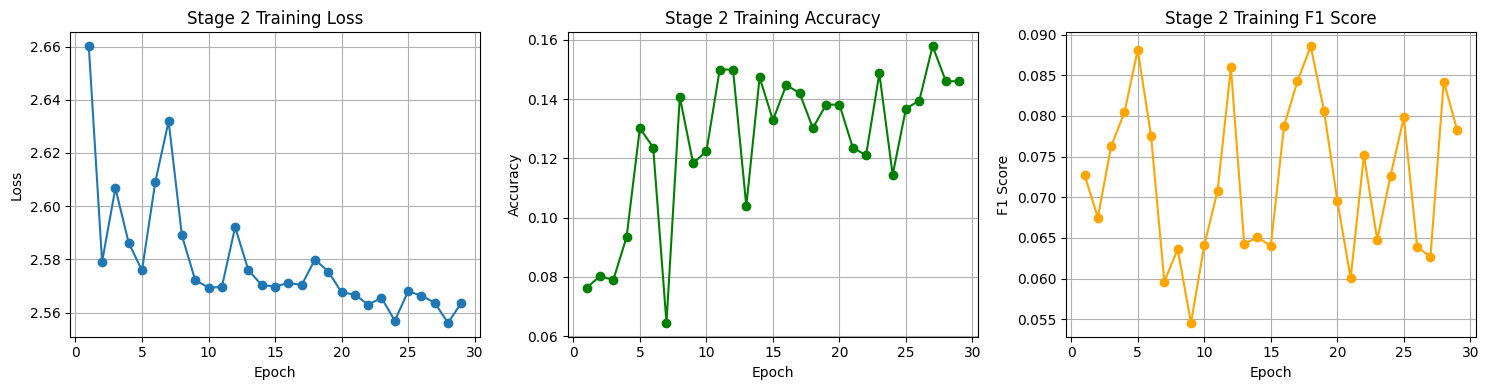

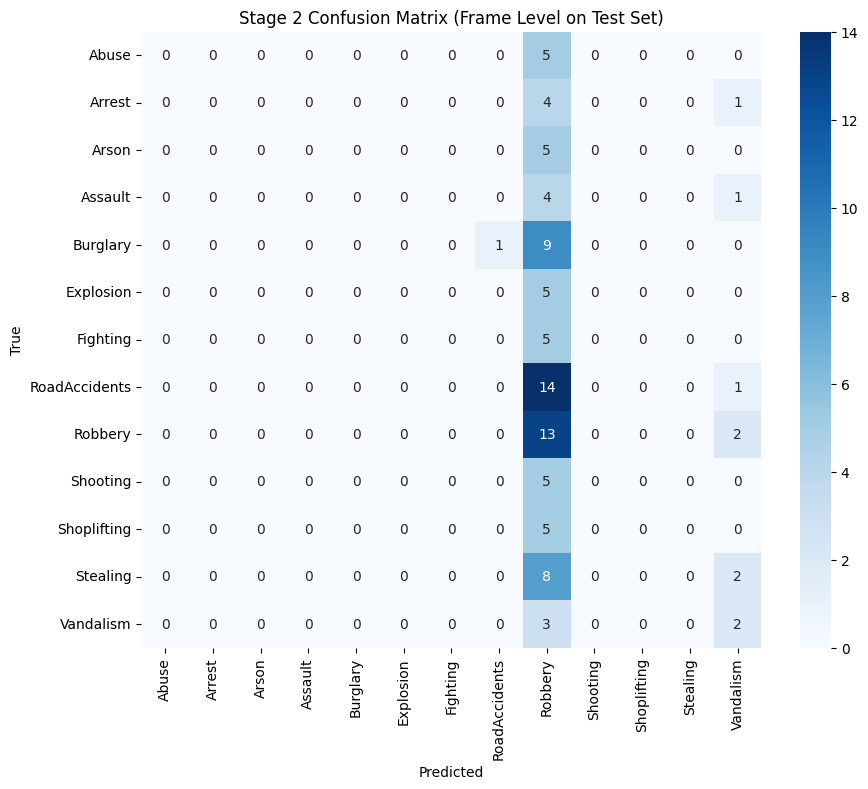

In [44]:
# --- STAGE 2 EVALUATION AND VISUALIZATION ---

def evaluate_stage2(loader, model, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    elapsed_time = time.time() - start_time
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Stage 2 evaluation completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
    return acc, f1, cm

# Evaluate on test set
test_acc, test_f1, test_cm = evaluate_stage2(test_loader_s2, model_s2, train_ds_s2.classes)
print(f"Stage 2 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 2 Test F1 Score: {test_f1:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(range(1, len(stage2_history['train_loss'])+1), stage2_history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 2 Training Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(stage2_history['train_acc'])+1), stage2_history['train_acc'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 2 Training Accuracy')
axes[1].grid(True)

# F1 Score plot
axes[2].plot(range(1, len(stage2_history['train_f1'])+1), stage2_history['train_f1'], marker='o', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Stage 2 Training F1 Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=train_ds_s2.classes, yticklabels=train_ds_s2.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 2 Confusion Matrix (Frame Level on Test Set)')
plt.show()

In [45]:
# --- STAGE 2: VIDEO-LEVEL CLASSIFICATION ---

def aggregate_frames_to_video_predictions(model, dataset_root, split_name, classes):
    """
    Aggregate frame-level predictions to video-level predictions.
    For each video, takes the most common predicted class across its frames.
    
    Args:
        model: Trained Stage 2 model
        dataset_root: Root directory containing extracted frames (STAGE_2_DATA_ROOT)
        split_name: "Train" or "Test"
        classes: List of class names from Stage 2
    
    Returns:
        video_predictions: Dict mapping video name to predicted class
        video_true_labels: Dict mapping video name to true class
        video_frame_predictions: Dict mapping video name to list of frame predictions
    """
    model.eval()
    
    split_path = os.path.join(dataset_root, split_name)
    video_predictions = {}
    video_true_labels = {}
    video_frame_predictions = {}
    
    start_time = time.time()
    
    # Iterate through each class folder
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Group frames by video name
        video_frames = {}
        for frame_file in os.listdir(class_path):
            if not frame_file.endswith('.jpg'):
                continue
            
            # Extract video name (format: VideoName_rankN.jpg)
            video_name = '_'.join(frame_file.split('_')[:-1])  # Remove _rankN.jpg
            
            if video_name not in video_frames:
                video_frames[video_name] = []
            
            video_frames[video_name].append(os.path.join(class_path, frame_file))
        
        # Process each video
        for video_name, frame_paths in video_frames.items():
            frame_preds = []
            
            with torch.no_grad():
                for frame_path in frame_paths:
                    # Load and preprocess frame
                    img = Image.open(frame_path).convert('RGB')
                    img_tensor = test_transform(img).unsqueeze(0).to(DEVICE)
                    
                    # Get prediction
                    output = model(img_tensor)
                    _, pred_idx = torch.max(output, 1)
                    pred_class = classes[pred_idx.item()]
                    
                    frame_preds.append(pred_class)
            
            # Store frame predictions for this video
            video_frame_predictions[video_name] = frame_preds
            
            # Aggregate: Most common prediction
            from collections import Counter
            most_common_pred = Counter(frame_preds).most_common(1)[0][0]
            
            video_predictions[video_name] = most_common_pred
            video_true_labels[video_name] = class_name
    
    elapsed_time = time.time() - start_time
    print(f"Video-level aggregation for {split_name} completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
    return video_predictions, video_true_labels, video_frame_predictions


def evaluate_video_level(video_predictions, video_true_labels, classes):
    """
    Evaluate video-level classification performance.
    
    Args:
        video_predictions: Dict mapping video name to predicted class
        video_true_labels: Dict mapping video name to true class
        classes: List of class names
    
    Returns:
        accuracy, f1_score, confusion_matrix
    """
    start_time = time.time()
    
    # Convert to lists for sklearn metrics
    true_labels = []
    pred_labels = []
    
    for video_name in video_predictions.keys():
        true_labels.append(video_true_labels[video_name])
        pred_labels.append(video_predictions[video_name])
    
    # Calculate metrics
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    
    elapsed_time = time.time() - start_time
    print(f"Stage 2 evaluation completed in {elapsed_time:.2f} seconds")
    
    return acc, f1, cm, true_labels, pred_labels


# Run Stage 2 video level evaluation on test set
print("=" * 70)
print("STAGE 2: VIDEO-LEVEL CLASSIFICATION")
print("=" * 70)

video_preds_test, video_true_test, video_frame_preds_test = aggregate_frames_to_video_predictions(
    model_s2, STAGE_2_DATA_ROOT, "Test", train_ds_s2.classes
)

video_acc, video_f1, video_cm, true_labels, pred_labels = evaluate_video_level(
    video_preds_test, video_true_test, train_ds_s2.classes
)

print(f"\nStage 2 Video-Level Test Accuracy: {video_acc*100:.2f}%")
print(f"Stage 2 Video-Level Test F1 Score: {video_f1:.4f}")
print(f"Total Videos Evaluated: {len(video_preds_test)}")

# Show some example predictions
print("\nSample Video Predictions:")
print(f"{'Video Name':<40} {'True':<15} {'Predicted':<15} {'Frame Votes'}")
print("-" * 90)
for i, (video_name, pred_class) in enumerate(list(video_preds_test.items())[:10]):
    true_class = video_true_test[video_name]
    frame_preds = video_frame_preds_test[video_name]
    from collections import Counter
    vote_summary = dict(Counter(frame_preds))
    print(f"{video_name:<40} {true_class:<15} {pred_class:<15} {vote_summary}")

# Visualize video-level confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(video_cm, annot=True, fmt='d', xticklabels=train_ds_s2.classes, 
            yticklabels=train_ds_s2.classes, cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Stage 2: Video-Level Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare Stage 2 (frame-level) vs Stage 2 (video-level) performance
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(f"Stage 2 (Frame-Level) Accuracy: {test_acc*100:.2f}%")
print(f"Stage 2 (Video-Level) Accuracy: {video_acc*100:.2f}%")
print(f"\nStage 2 (Frame-Level) F1 Score: {test_f1:.4f}")
print(f"Stage 2 (Video-Level) F1 Score: {video_f1:.4f}")
print("=" * 70)

STAGE 2: VIDEO-LEVEL CLASSIFICATION


RuntimeError: Given groups=1, weight of size [48, 3, 3, 7, 7], expected input[1, 1, 3, 224, 224] to have 3 channels, but got 1 channels instead